In [116]:
import pandas as pd
import numpy as np
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

df = pd.read_csv("Titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The 'Passenger ID', 'Name', 'Ticket' and 'Embarked' columns do not seem to be very useful for this survival factor analysis, so we will remove them.

In [117]:
df.drop('PassengerId',axis=1, inplace=True)
df.drop('Name',axis=1, inplace=True)
df.drop('Ticket',axis=1, inplace=True)
df.drop('Embarked',axis=1, inplace=True)
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,male,22.0,1,0,7.2500,NaN
1,1,1,female,38.0,1,0,71.2833,C85
2,1,3,female,26.0,0,0,7.9250,NaN
3,1,1,female,35.0,1,0,53.1000,C123
4,0,3,male,35.0,0,0,8.0500,NaN
5,0,3,male,NaN,0,0,8.4583,NaN
6,0,1,male,54.0,0,0,51.8625,E46
7,0,3,male,2.0,3,1,21.0750,NaN
8,1,3,female,27.0,0,2,11.1333,NaN
9,1,2,female,14.0,1,0,30.0708,NaN


From this data we can deduce the following:
- 'Survived' is classified with the values '1' or '0', meaning that '1' is survivor and '0' non-survivor.
- 'Pclass' shows the passenger class, which are either '1' or '2' or '3'. At the moment, it is not known in which order it goes from highest to lowest class.
- 'Gender' female or male.
- 'Age' are the values to difference men/women from children. In addition, there are missing data.
- 'SibSp' refers to the number of siblings or spouses travelling with each passenger on board.
- 'Parch' refers to the number of parents or children travelling with each passenger on board. 
- 'Fare' refers to the price paid for the ticket.
- 'Cabin' if the passenger was allocated a cabin. We can see that not everyone was allocated a cabin, so this may be a sign of the passenger's class.

In [118]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:8]

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
dtype: int64

The only columns missing data are 'Age' and 'Cabin'. In 'Age' the only thing I can think of is that the missing data is due to underage passengers, or to someone who has travelled alone and has had an oversight. As for 'Cabin' I am sure that the missing data is due to the fact that they have not purchased a cabin.

We will start by comparing the data between 'Pclass' and 'Fare'.

In [119]:
fare_mean_by_class = df.groupby('Pclass')['Fare'].mean()
print(fare_mean_by_class)

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


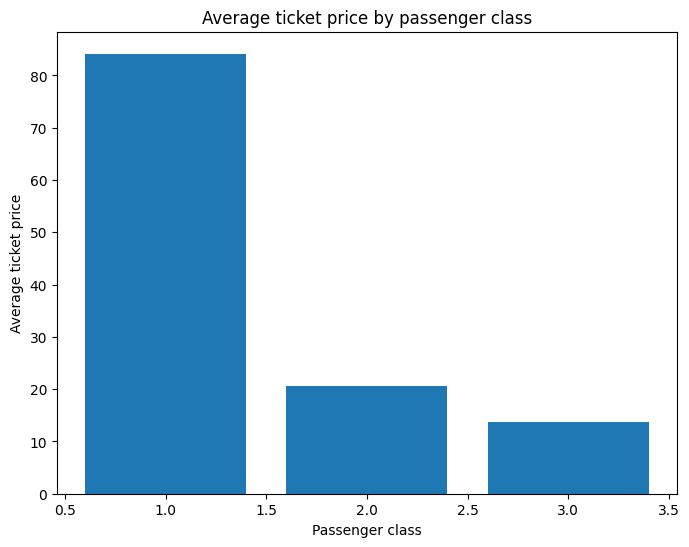

In [120]:
plt.figure(figsize=(8, 6))
plt.bar(fare_mean_by_class.index, fare_mean_by_class.values)
plt.xlabel('Passenger class')
plt.ylabel('Average ticket price')
plt.title('Average ticket price by passenger class')
plt.show()

Here we can clearly see that Class 1 is the upper class, Class 2 is the middle class, and Class 3 is the lower class. Now let's compare how many people survived from each class, and their percentage.

In [121]:
# How many people in total by class
total_class = df.groupby(['Pclass'])['Survived'].count()
# How many people survived by class
survived_class = df.groupby(['Pclass'])['Survived'].sum()
survival_percentage = (survived_class / total_class) * 100
print('Number of passengers per class:', total_class)
print('Number of passenger that survived per class:', survived_class)
print('Survival percentage of passengers per class:', survival_percentage)

Number of passengers per class: Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64
Number of passenger that survived per class: Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64
Survival percentage of passengers per class: Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


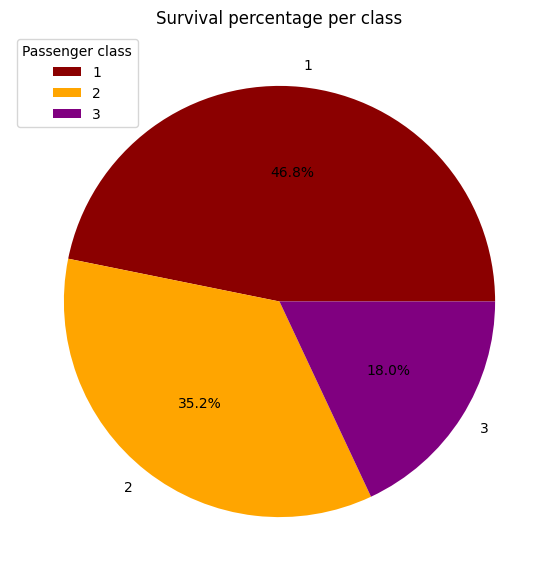

In [122]:
# Bar plot to show the percentage comparision
plt.figure(figsize=(9, 7))
plt.pie(survival_percentage, labels=survival_percentage.index,autopct='%1.1f%%', colors=['darkred', 'orange','purple'])
plt.legend(survival_percentage.index, title='Passenger class', loc='upper left')
plt.title('Survival percentage per class')
plt.show()

We can confirm that the higher the passenger's class, the better the chances of survival. So it is very likely that upper class passengers were given preference for access to the lifeboats.

We will now analyse the relationship between the data on men, women and children, to see if it is true that it was the case that women and children were preferred. To do this we will visualise the age distribution; compare the age distribution between groups; analyse age-related characteristics; and impute missing ages based on other characteristics.

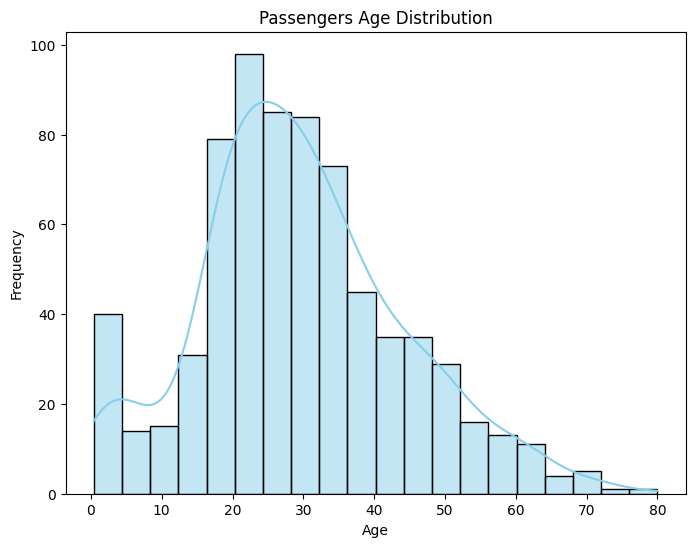

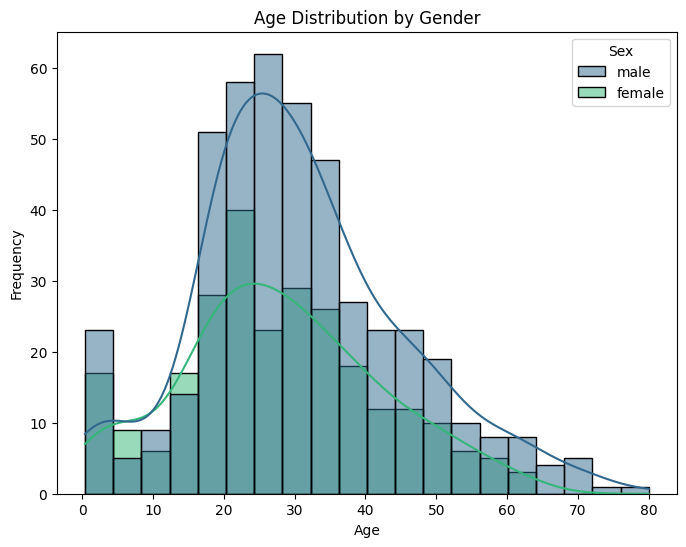

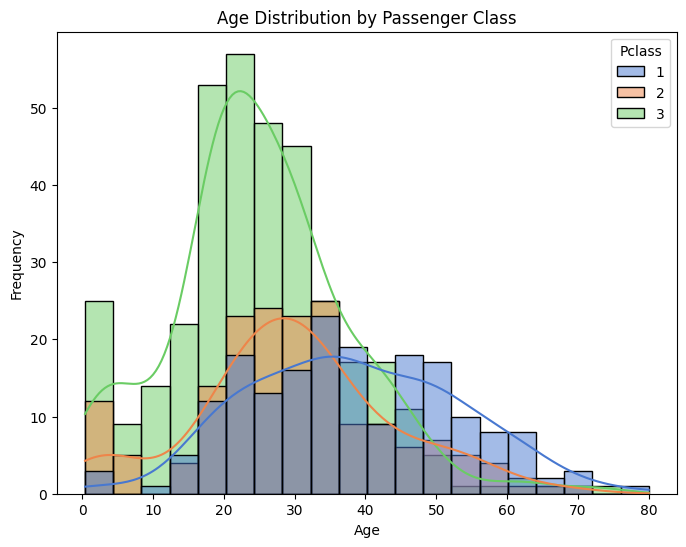

In [123]:
# Visualise the age distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Passengers Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Compare age distribution between men and women
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', hue='Sex', bins=20, kde=True, palette='viridis')
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Compare age distribution between different passenger classes
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', hue='Pclass', bins=20, kde=True, palette='muted')
plt.title('Age Distribution by Passenger Class')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


We can see that in terms of age distribution, there are more adults than children, but that there is a considerable amount of passengers between approximately 16-21 years old. Then, the age distribution by gender in general terms is quite similar (always with male predominance), but if we look at the age range between approximately 16-36 years, the difference between men and women is very large, in favour of men. And in terms of age distribution by passenger class it is the same, more or less equal, but in the range of approximately 16-32 years, the number of passengers in Class 3 is considerably higher than in the rest of the classes.

For the moment, with the passengers who have the full value of 'Age' I will compare the survival rate between adults, women and men, and children(under 18 y.o).

In [124]:
male_passengers = df[df['Sex'] == 'male']
female_passengers = df[df['Sex'] == 'female']
children_passengers = df[df['Age'] < 18] 
survival_male = (male_passengers['Survived'].mean()) * 100
survival_female = (female_passengers['Survived'].mean()) * 100
survival_children = (children_passengers['Survived'].mean()) * 100
print('Survival rate by men:', survival_male, '%')
print('Survival rate by women:', survival_female, '%')
print('Survival rate by children:', survival_children, '%')

Survival rate by men: 18.890814558058924 %
Survival rate by women: 74.20382165605095 %
Survival rate by children: 53.98230088495575 %


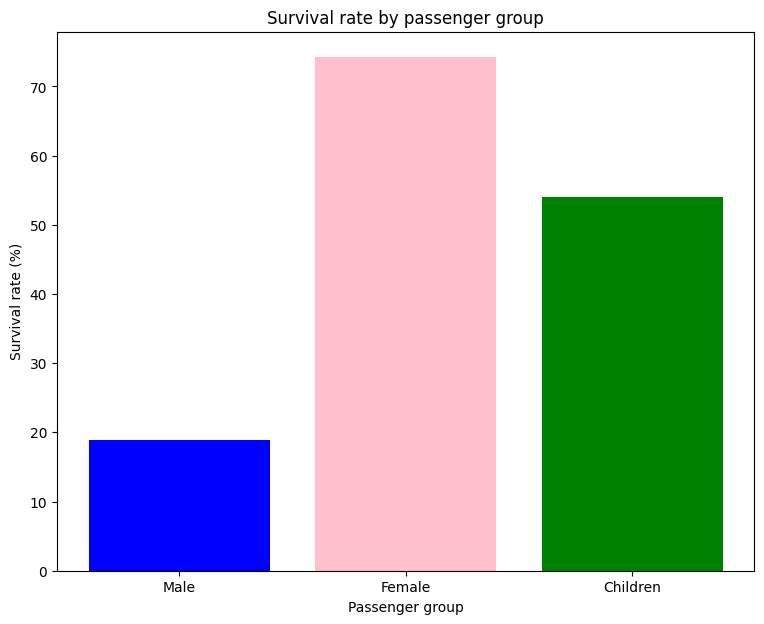

In [125]:
categories = ['Male', 'Female', 'Children']
survival_rates = [survival_male, survival_female, survival_children]
plt.figure(figsize=(9, 7))
plt.bar(categories, survival_rates, color=['blue', 'pink', 'green'])
plt.xlabel('Passenger group')
plt.ylabel('Survival rate (%)')
plt.title('Survival rate by passenger group')
plt.show()


In [126]:
# Count the number of missing values in the 'Age' column
missing_values = df['Age'].isnull().sum()

# Calculate the percentage of missing values
total_rows = len(df)
percentage_missing = (missing_values / total_rows) * 100
print("Percentage of missing values in the 'Age' column:", percentage_missing, '%')


Percentage of missing values in the 'Age' column: 19.865319865319865 %


It can be seen that the majority of women survived (74%); just over half of the children survived (54%); and that the majority of men failed to survive (19%). It is worth remembering that these are the data for those who have the full value of the 'Age' column. As 20% of the data is missing in the 'Age' column, let's try to find out what could be the age of these people, comparing survival rates with gender.

In [127]:
missing_age_passengers = df[df['Age'].isnull()]
survival_ratio_male = (missing_age_passengers[missing_age_passengers['Sex'] == 'male']['Survived'].mean()) * 100
survival_ratio_female = (missing_age_passengers[missing_age_passengers['Sex'] == 'female']['Survived'].mean()) * 100
print("Survival ratio for males with missing age:", survival_ratio_male, "%")
print("Survival ratio for females with missing age:", survival_ratio_female, "%")


Survival ratio for males with missing age: 12.903225806451612 %
Survival ratio for females with missing age: 67.9245283018868 %


We see that the survival rate of male (13%) and female (68%) passengers with incomplete Age values are very similar to those with complete Age values, so we can assume that the survival rate of children will also be close to a 50% survival rate. Women and children, therefore, are more likely to have had a preference for escaping the sinking of the Titanic by lifeboat than men.

We will now compare the survival rate between passengers with and without cabin information.

In [129]:
with_cabin = df[df['Cabin'].notnull()]
without_cabin = df[df['Cabin'].isnull()]
survival_with_cabin = with_cabin['Survived'].mean() * 100
survival_without_cabin = without_cabin['Survived'].mean() * 100
print("Survival rate for passengers with cabin information:", survival_with_cabin, "%")
print("Survival rate for passengers without cabin information:", survival_without_cabin, "%")


Survival rate for passengers with cabin information: 66.66666666666666 %
Survival rate for passengers without cabin information: 29.985443959243085 %


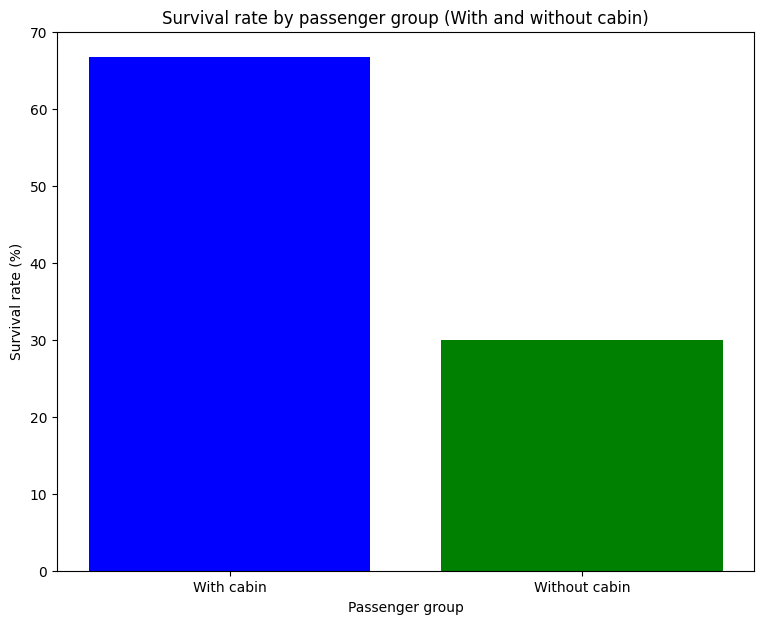

In [130]:
categories = ['With cabin', 'Without cabin']
survival_rates = [survival_with_cabin, survival_without_cabin]
plt.figure(figsize=(9, 7))
plt.bar(categories, survival_rates, color=['blue', 'green'])
plt.xlabel('Passenger group')
plt.ylabel('Survival rate (%)')
plt.title('Survival rate by passenger group (With and without cabin)')
plt.show()

From this we can deduce that the cabin factor is remarkable, as 67% of those who had a cabin survived, while only 30% of those who did not have a cabin survived.

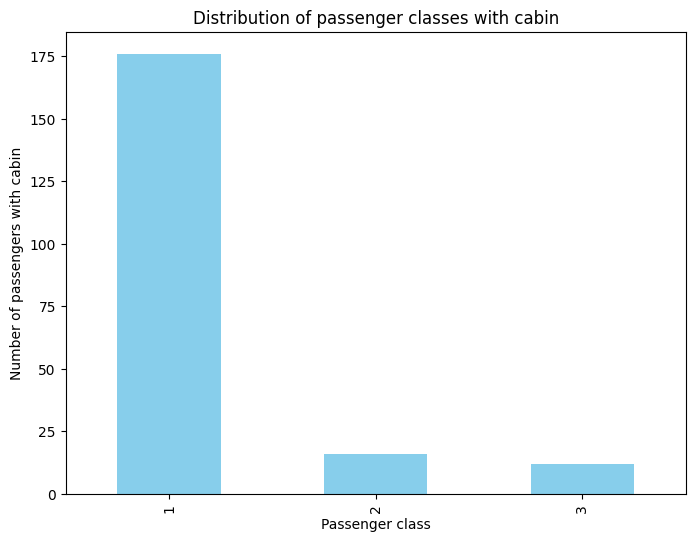

In [131]:
cabin = df[df['Cabin'].notnull()]
cabin_class_counts = cabin['Pclass'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
cabin_class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Passenger class')
plt.ylabel('Number of passengers with cabin')
plt.title('Distribution of passenger classes with cabin')
plt.show()

With this graph we can see that Class 1, were the ones who mostly obtained cabins, thus helping the survival of the accident.

Text(0.5, 1.0, 'Percentage of Class 1 passengers with cabin and survival difference')

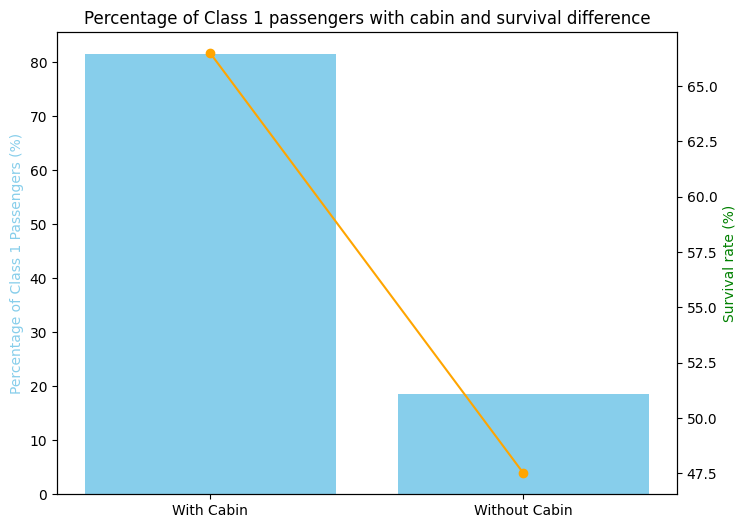

In [133]:
class_1_passengers = df[df['Pclass'] == 1]

# Calculate the percentage of class 1 passengers who got a cabin
total_class_1_passengers = len(class_1_passengers)
class_1_with_cabin = class_1_passengers[class_1_passengers['Cabin'].notnull()]
percentage_class_1_with_cabin = (len(class_1_with_cabin) / total_class_1_passengers) * 100

# Calculate the survival rate for class 1 passengers with and without cabin
survival_rate_class_1_with_cabin = class_1_with_cabin['Survived'].mean() * 100
survival_rate_class_1_without_cabin = class_1_passengers[class_1_passengers['Cabin'].isnull()]['Survived'].mean() * 100

# Calculate the survival difference between both groups
survival_difference = survival_rate_class_1_with_cabin - survival_rate_class_1_without_cabin

labels = ['With Cabin', 'Without Cabin']
values = [percentage_class_1_with_cabin, 100 - percentage_class_1_with_cabin]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(labels, values, color='skyblue')
ax1.set_ylabel('Percentage of Class 1 Passengers (%)', color='skyblue')
ax2 = ax1.twinx()
ax2.plot(labels, [survival_rate_class_1_with_cabin, survival_rate_class_1_without_cabin], color='orange', marker='o')
ax2.set_ylabel('Survival rate (%)', color='green')
plt.title('Percentage of Class 1 passengers with cabin and survival difference')


However, it can be seen that more than 80% of class 1 passengers purchased while the remaining 20% did not, but the difference in survival rate is not much higher even so.

All in all, these are the most important factors that determined survival on the Titanic:
- Class. All those in Class 1 belonged to the highest class, which gave them preference over other classes when it came to evacuating the Titanic in a lifeboat.
- Gender and age: Women and children have a much higher survival rate than men, which is very low. It is quite likely that it was a case of "Women and children first".
- Cabin: Most people who stayed in a cabin had a chance of survival, however, people who did not stay in cabins had a very low survival rate. It is worth noting that almost the absolute majority of those who bought a cabin were in Class 1.